In [1]:
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from generate_network_nodes import generate_network
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments, ArrayOutcome, Samplers
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant, SequentialEvaluator
import time

In [3]:
def AddNodeEffect(r, p, c, x_m, additional_nodes=0, n=0, vis=False, o=24,
                                  random_data=False, load=1, seed=None):
    """abc
    Parameters
    ----------
    load:float
        Percentage of vessels on the network compared to the 2021 total.

    r:int
        Range of a vessel.

    additional_nodes: int
        Number of additional nodes that should be inserted into the original network.
    """
    G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
    df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
    df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
    path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
    paths = pickle.load(open('data/final_paths.p', "rb"))

    # generate random data
    if random_data:
        df_random = random_vessel_generator(df_ivs, seed, load)
        flows = flow_computation(df_random, r, path_lengths)
    else:
        df_random = df_ivs
        flows = flow_computation(df_random, r, path_lengths)

    inserted = []

    if additional_nodes == 3:
        G, paths, inserted = generate_network(G, paths, n)
        inserted += additional_intersections(G, n)
    elif additional_nodes == 2:
        G, paths, inserted = generate_network(G, paths, n)
    elif additional_nodes == 1:
        inserted += additional_intersections(G, n)

    # execute first stage, with or without additional nodes
    df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(r, G, OD=flows, paths=paths,
                                                                   path_lengths=path_lengths, df_h=df_h,
                                                                   additional_nodes=inserted)

#     # execute second stage
#     optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(
#         p, x_m, c, o, df_g, df_b, df_eq_fq)

    # collect data
    total_flow = sum(flows.values())

    max_supported = {i: flows[i] for i in flows if len(feasible_combinations[i]) > 0}
    max_supported = sum(max_supported.values())

#     fraction_captured_total = (supported_flow / total_flow)

    serviceable_fraction = (max_supported / total_flow)

#     served_fraction = (supported_flow / max_supported)

#     used_facilities = [i for i, j in optimal_facilities.items() if j > 0]
#     add_nodes_used = float(len(list(set(used_facilities) - set(df_h.harbour_node.to_list()))))

#     if vis:
#         visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)

    return serviceable_fraction, total_flow

In [4]:
%%time
serviceable_fraction = AddNodeEffect(50000, 10, 2000, 5, n=40)

CPU times: total: 1.05 s
Wall time: 1.72 s


In [5]:
serviceable_fraction

(0.08112930846266861, 2941841.1904762224)

In [6]:
#define model
model = Model("AddNodeEffect", function=AddNodeEffect)

In [7]:
#define parameters
model.constants = [
    Constant('p', 40),
    Constant('c', 2500),
    Constant('x_m', 5),
    Constant("random_data", False),
    Constant("additional_nodes", 2)
]

#define parameters
model.uncertainties = [
    CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]),
]

# set levers
model.levers = [
    CategoricalParameter('n', [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome('total_flow')
]

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(model) as evaluator:
# with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=11, policies=11, uncertainty_sampling=Samplers.FF, lever_sampling=Samplers.FF)

[MainProcess/INFO] performing 11 scenarios * 11 policies * 1 model(s) = 121 experiments
  0%|                                                  | 0/121 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  1%|▎                                         | 1/121 [00:01<02:28,  1.23s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  2%|▋                                         | 2/121 [00:02<02:31,  1.27s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  2%|█                                         | 3/121 [00:04<02:43,  1.39s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  3%|█▍                                        | 4/121 [00:05<02:56,  1.51s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  4%|█▋                                        | 5/121 [00:07<03:09,  1.64s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  5%|██                                        | 6/121 [00:09<03:19,  1.73s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  6%|██▍                                       | 7/121 [00:11<03:37,  1.91s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  7%|██▊                                       | 8/121 [00:14<03:57,  2.10s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  7%|███                                       | 9/121 [00:17<04:23,  2.35s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  8%|███▍                                     | 10/121 [00:20<04:44,  2.56s/it]

There were 0 nodes added, the longest remaining link is now: 75895.64343792459


  9%|███▋                                     | 11/121 [00:23<05:07,  2.80s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 10%|████                                     | 12/121 [00:25<04:46,  2.63s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 11%|████▍                                    | 13/121 [00:28<04:38,  2.58s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 12%|████▋                                    | 14/121 [00:31<04:41,  2.63s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 12%|█████                                    | 15/121 [00:34<05:03,  2.86s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 13%|█████▍                                   | 16/121 [00:38<05:28,  3.13s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 14%|█████▊                                   | 17/121 [00:42<05:52,  3.39s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 15%|██████                                   | 18/121 [00:46<06:19,  3.68s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 16%|██████▍                                  | 19/121 [00:52<07:16,  4.27s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 17%|██████▊                                  | 20/121 [00:58<07:59,  4.75s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 17%|███████                                  | 21/121 [01:03<08:28,  5.09s/it]

There were 10 nodes added, the longest remaining link is now: 44873.36495810296


 18%|███████▍                                 | 22/121 [01:10<09:02,  5.48s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 19%|███████▊                                 | 23/121 [01:13<07:55,  4.85s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 20%|████████▏                                | 24/121 [01:17<07:16,  4.50s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 21%|████████▍                                | 25/121 [01:21<07:02,  4.40s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 21%|████████▊                                | 26/121 [01:26<07:08,  4.51s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 22%|█████████▏                               | 27/121 [01:31<07:28,  4.77s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 23%|█████████▍                               | 28/121 [01:37<07:53,  5.09s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 24%|█████████▊                               | 29/121 [01:43<08:20,  5.44s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 25%|██████████▏                              | 30/121 [01:51<09:26,  6.22s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 26%|██████████▌                              | 31/121 [02:00<10:29,  7.00s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 26%|██████████▊                              | 32/121 [02:09<11:19,  7.63s/it]

There were 20 nodes added, the longest remaining link is now: 37699.72213501075


 27%|███████████▏                             | 33/121 [02:19<12:09,  8.29s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 28%|███████████▌                             | 34/121 [02:26<11:21,  7.83s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 29%|███████████▊                             | 35/121 [02:33<10:52,  7.59s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 30%|████████████▏                            | 36/121 [02:41<10:55,  7.71s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 31%|████████████▌                            | 37/121 [02:51<11:37,  8.30s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 31%|████████████▉                            | 38/121 [03:01<12:24,  8.97s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 32%|█████████████▏                           | 39/121 [03:13<13:16,  9.72s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 33%|█████████████▌                           | 40/121 [03:25<14:19, 10.61s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 34%|█████████████▉                           | 41/121 [03:39<15:34, 11.68s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 35%|██████████████▏                          | 42/121 [03:55<16:43, 12.70s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 36%|██████████████▌                          | 43/121 [04:10<17:43, 13.63s/it]

There were 30 nodes added, the longest remaining link is now: 31379.45313872912


 36%|██████████████▉                          | 44/121 [04:27<18:45, 14.61s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 37%|███████████████▏                         | 45/121 [04:38<17:00, 13.43s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 38%|███████████████▌                         | 46/121 [04:50<16:22, 13.10s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 39%|███████████████▉                         | 47/121 [05:04<16:29, 13.37s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 40%|████████████████▎                        | 48/121 [05:21<17:40, 14.53s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 40%|████████████████▌                        | 49/121 [05:40<18:53, 15.74s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 41%|████████████████▉                        | 50/121 [06:02<20:46, 17.56s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 42%|█████████████████▎                       | 51/121 [06:25<22:36, 19.38s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 43%|█████████████████▌                       | 52/121 [06:51<24:24, 21.22s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 44%|█████████████████▉                       | 53/121 [07:18<26:05, 23.03s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 45%|██████████████████▎                      | 54/121 [07:48<27:55, 25.01s/it]

There were 40 nodes added, the longest remaining link is now: 26901.63642071443


 45%|██████████████████▋                      | 55/121 [08:16<28:23, 25.81s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 46%|██████████████████▉                      | 56/121 [08:41<27:55, 25.78s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 47%|███████████████████▎                     | 57/121 [09:13<29:30, 27.66s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 48%|███████████████████▋                     | 58/121 [09:59<34:45, 33.11s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 49%|███████████████████▉                     | 59/121 [10:53<40:34, 39.26s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 50%|████████████████████▎                    | 60/121 [11:55<46:47, 46.02s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 50%|████████████████████▋                    | 61/121 [12:58<51:15, 51.26s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 51%|█████████████████████                    | 62/121 [14:05<55:11, 56.13s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 52%|█████████████████████▎                   | 63/121 [15:12<57:11, 59.16s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 53%|█████████████████████▋                   | 64/121 [16:23<59:38, 62.79s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 54%|████████████████████▉                  | 65/121 [17:38<1:02:07, 66.56s/it]

There were 50 nodes added, the longest remaining link is now: 25289.716355056917


 55%|█████████████████████▎                 | 66/121 [19:01<1:05:26, 71.39s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 55%|██████████████████████▋                  | 67/121 [19:34<53:54, 59.90s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 56%|███████████████████████                  | 68/121 [20:16<48:05, 54.45s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 57%|███████████████████████▍                 | 69/121 [21:08<46:30, 53.66s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 58%|███████████████████████▋                 | 70/121 [22:08<47:23, 55.75s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 59%|████████████████████████                 | 71/121 [23:18<49:53, 59.86s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 60%|████████████████████████▍                | 72/121 [24:35<53:09, 65.09s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 60%|████████████████████████▋                | 73/121 [26:00<56:57, 71.20s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 61%|███████████████████████▊               | 74/121 [27:33<1:00:43, 77.52s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 62%|████████████████████████▏              | 75/121 [29:09<1:03:44, 83.14s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 63%|████████████████████████▍              | 76/121 [30:50<1:06:20, 88.46s/it]

There were 60 nodes added, the longest remaining link is now: 23039.698710314668


 64%|████████████████████████▊              | 77/121 [32:34<1:08:19, 93.17s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 64%|██████████████████████████▍              | 78/121 [33:12<54:51, 76.55s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 65%|██████████████████████████▊              | 79/121 [34:01<47:55, 68.46s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 66%|███████████████████████████              | 80/121 [35:02<45:10, 66.11s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 67%|███████████████████████████▍             | 81/121 [36:12<44:51, 67.28s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 68%|███████████████████████████▊             | 82/121 [37:38<47:27, 73.01s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 69%|████████████████████████████             | 83/121 [39:15<50:40, 80.02s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 69%|████████████████████████████▍            | 84/121 [41:00<54:05, 87.71s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 70%|████████████████████████████▊            | 85/121 [42:53<57:06, 95.19s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 71%|████████████████████████████▍           | 86/121 [44:52<59:44, 102.41s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 72%|███████████████████████████▎          | 87/121 [46:57<1:01:47, 109.04s/it]

There were 70 nodes added, the longest remaining link is now: 21847.570674122773


 73%|███████████████████████████▋          | 88/121 [48:58<1:01:57, 112.64s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 74%|██████████████████████████████▏          | 89/121 [50:07<53:05, 99.56s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 74%|██████████████████████████████▍          | 90/121 [51:35<49:42, 96.22s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 75%|██████████████████████████████▊          | 91/121 [53:21<49:35, 99.17s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 76%|██████████████████████████████▍         | 92/121 [55:23<51:08, 105.79s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 77%|██████████████████████████████▋         | 93/121 [57:57<56:13, 120.50s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 78%|███████████████████████████▉        | 94/121 [1:00:57<1:02:10, 138.16s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 79%|████████████████████████████▎       | 95/121 [1:04:35<1:10:19, 162.30s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 79%|████████████████████████████▌       | 96/121 [1:08:31<1:16:46, 184.25s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 80%|████████████████████████████▊       | 97/121 [1:12:42<1:21:44, 204.34s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 81%|█████████████████████████████▏      | 98/121 [1:17:11<1:25:45, 223.72s/it]

There were 80 nodes added, the longest remaining link is now: 20043.559412023216


 82%|█████████████████████████████▍      | 99/121 [1:21:57<1:28:50, 242.29s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 83%|████████████████████████████▉      | 100/121 [1:24:19<1:14:20, 212.40s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 83%|█████████████████████████████▏     | 101/121 [1:27:32<1:08:52, 206.62s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 84%|█████████████████████████████▌     | 102/121 [1:31:46<1:09:51, 220.62s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 85%|█████████████████████████████▊     | 103/121 [1:36:38<1:12:39, 242.20s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 86%|██████████████████████████████     | 104/121 [1:42:43<1:19:00, 278.88s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 87%|██████████████████████████████▎    | 105/121 [1:49:37<1:25:12, 319.52s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 88%|██████████████████████████████▋    | 106/121 [1:57:46<1:32:37, 370.47s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 88%|██████████████████████████████▉    | 107/121 [2:06:32<1:37:17, 416.96s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 89%|███████████████████████████████▏   | 108/121 [2:15:52<1:39:36, 459.76s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 90%|███████████████████████████████▌   | 109/121 [2:25:40<1:39:38, 498.23s/it]

There were 90 nodes added, the longest remaining link is now: 18831.21318081247


 91%|███████████████████████████████▊   | 110/121 [2:36:24<1:39:24, 542.23s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 92%|████████████████████████████████   | 111/121 [2:44:14<1:26:45, 520.57s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 93%|████████████████████████████████▍  | 112/121 [2:54:45<1:23:00, 553.42s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 93%|████████████████████████████████▋  | 113/121 [3:07:48<1:23:00, 622.53s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 94%|████████████████████████████████▉  | 114/121 [3:23:19<1:23:24, 714.90s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 95%|█████████████████████████████████▎ | 115/121 [3:42:57<1:25:23, 853.93s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 96%|████████████████████████████████▌ | 116/121 [4:07:33<1:26:42, 1040.53s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 97%|████████████████████████████████▉ | 117/121 [4:35:36<1:22:13, 1233.40s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 98%|█████████████████████████████████▏| 118/121 [5:05:36<1:10:09, 1403.14s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 98%|███████████████████████████████████▍| 119/121 [5:38:18<52:21, 1570.82s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


 99%|███████████████████████████████████▋| 120/121 [6:12:12<28:29, 1709.72s/it]

There were 100 nodes added, the longest remaining link is now: 17397.58257727829


100%|█████████████████████████████████████| 121/121 [6:48:53<00:00, 202.75s/it]
[MainProcess/INFO] experiments finished


In [ ]:
# %%time
# plot_dict = {'r':[], 'additional_nodes':[], 'add_nodes_in_routes':[], 'servable_fraction':[]}
# for r in np.arange(40000, 150000, 10000):
#     for add_nodes in np.arange(0, 101, 10):
#         additional_nodes, serveable_fraction = AddNodeEffect(r, add_nodes)
#         plot_dict['r'].append(r)
#         plot_dict['additional_nodes'].append(add_nodes)
#         # plot_dict['add_nodes_in_routes'].append(extra_nodes_used)
#         plot_dict['servable_fraction'].append(serveable_fraction)
#         print(r, add_nodes)


In [3]:
# pickle.dump( experiments, open( "results/experiments_increasing_range_and_n.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_increasing_range_and_n.p", "wb") )
experiments = pickle.load(open("results/experiments_increasing_range_and_n.p", "rb"))
outcomes = pickle.load(open("results/outcomes_increasing_range_and_n.p", "rb"))

In [4]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

In [17]:
np.arange(50000, 150001, 20000)

array([ 50000,  70000,  90000, 110000, 130000, 150000])

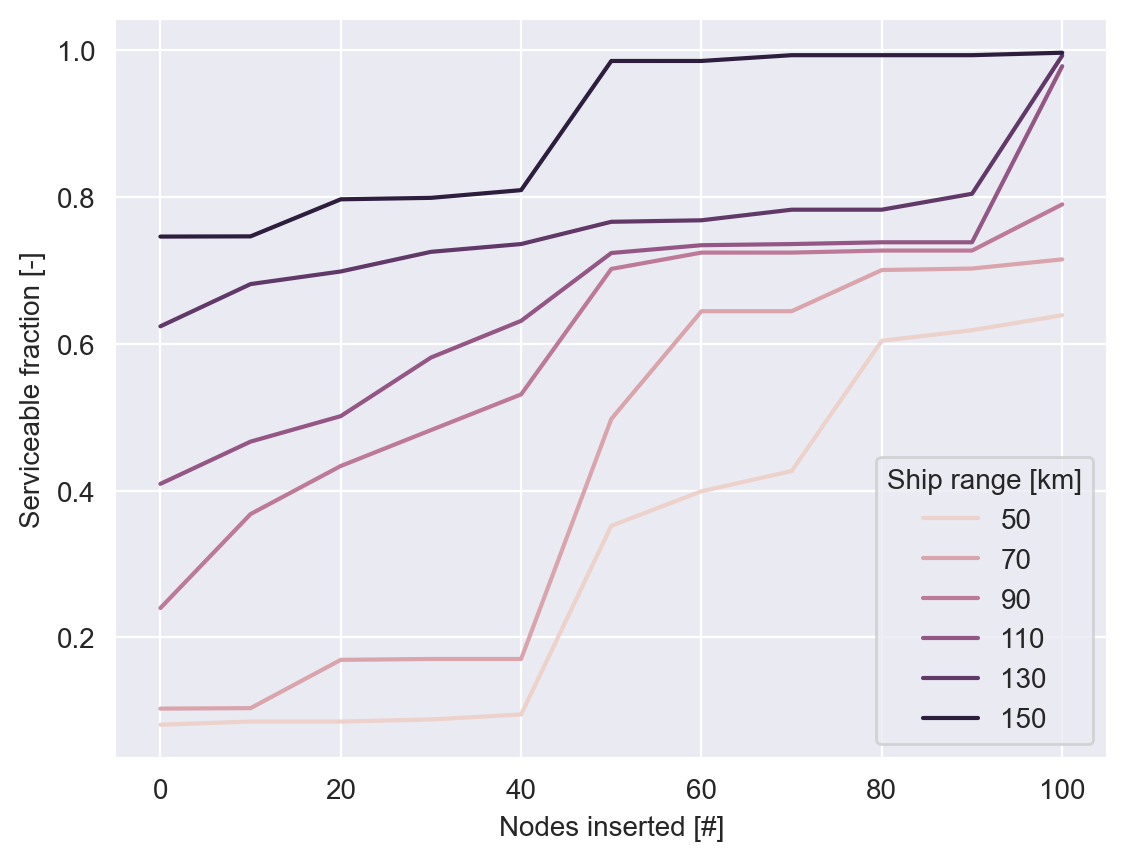

In [23]:
plt.subplots(dpi=200)
sns.lineplot(x='n', y='serviceable_fraction', hue='r', data=df.loc[df.r.isin(np.arange(50000, 150001, 20000))])
plt.xlabel("Nodes inserted [#]")
plt.ylabel("Serviceable fraction [-]")
# plt.legend(title='Ship range',labels=['50km', '60km', '70km', '80km', '90km', '100km', '110km', '120km', '130km', '140km', '150km'])
plt.legend(title='Ship range [km]',labels=['50', '70', '90', '110', '130', '150'])
plt.show()

In [ ]:
plot_dict1 = pickle.load(open('data/plot_dict_0_100_till150.p', 'rb'))
plot_dict2 = pickle.load(open('data/plot_dict_0_70_175-250.p', 'rb'))

In [ ]:
plot_dict1 = pd.DataFrame.from_dict(plot_dict1)
plot_dict2 = pd.DataFrame.from_dict(plot_dict2)

In [ ]:
plot_dict = pd.concat([plot_dict1, plot_dict2])

In [ ]:
plot_dictl

In [ ]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

In [ ]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()

In [ ]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

In [ ]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()

## New

In [1]:
import networkx as nx
import pickle
import pandas as pd
import geopy.distance
import matplotlib.pyplot as plt
from generate_network import generate_network
pd.options.mode.chained_assignment = None  # default='warn'

G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
paths = pickle.load(open('data/final_paths.p', "rb"))

df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

r= 70000

In [2]:
G, paths, inserted = generate_network(G, paths)

There were 34 nodes added, the longest remaining link is now: 29452.788060354498


In [3]:
from determine_additional_nodes import determine_additional_nodes

additional_intersections = determine_additional_nodes(G, df_h, r)


5 intersections were added


In [4]:
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

In [5]:
edge_list1 = []
for i in range(len(paths[('NLAMS', 'NLOSS', 0)])-1):
    edge_list1.append((paths[('NLAMS', 'NLOSS', 0)][i],paths[('NLAMS', 'NLOSS', 0)][i+1]))

In [6]:
edge_list1

[('8866429', '8863656'),
 ('8863656', '8863272'),
 ('8863272', '8866747'),
 ('8866747', '8863796'),
 ('8863796', '8862592'),
 ('8862592', '8864384'),
 ('8864384', '8865887'),
 ('8865887', '8864837'),
 ('8864837', '8860732'),
 ('8860732', '8865846'),
 ('8865846', '8866095'),
 ('8866095', '8860631'),
 ('8860631', '8862340'),
 ('8862340', '8862202'),
 ('8862202', '8861996'),
 ('8861996', '8865631'),
 ('8865631', '8865735'),
 ('8865735', '8865119'),
 ('8865119', '8860920'),
 ('8860920', '8862570')]

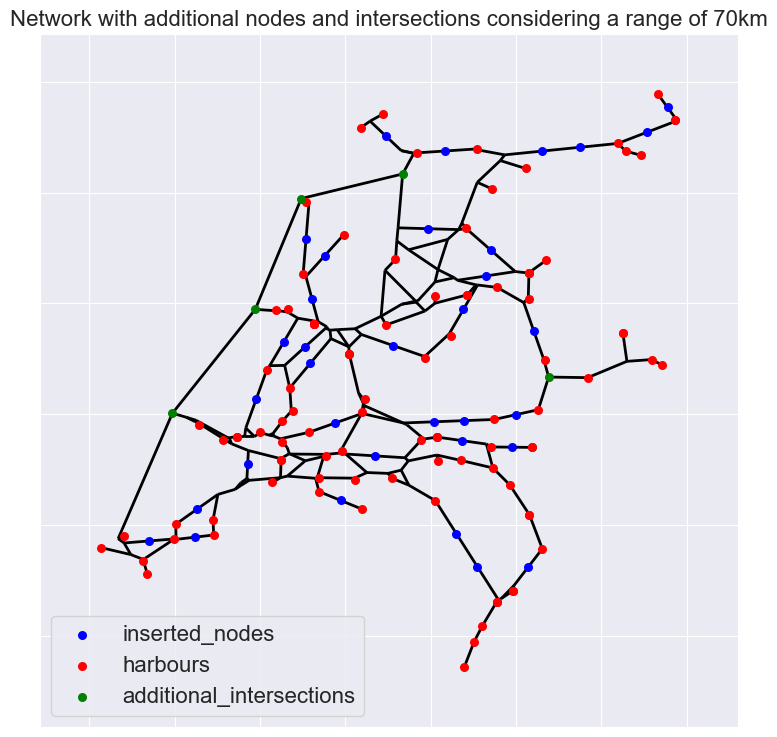

In [7]:
fig, ax = plt.subplots(figsize=(9,9), dpi=100)
nx.draw_networkx_edges(G, pos_dict, width=2, ax=ax)
# nx.draw_networkx_edges(G, pos_dict,edge_list1, width=2, edge_color='r', label='route AMS to OSS')
# nx.draw_networkx_nodes(G, pos_dict, node_size=30)
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=30, node_color = 'b', label = 'inserted_nodes')
nx.draw_networkx_nodes(G, pos_dict, list(df_h.harbour_node), node_size=30, node_color = 'r', label='harbours')
nx.draw_networkx_nodes(G, pos_dict, list(additional_intersections), node_size=30, node_color = 'g', label='additional_intersections')
# nx.draw_networkx_nodes(G, pos_dict, ['8866763', '8864837', '8862570'], node_size=30, node_color = 'y', label='harbours on route')
plt.title("Network with additional nodes and intersections considering a range of 70km", fontsize=16)
plt.legend(fontsize=16)
plt.show()